# Evalution and Analysis

## Imports:

In [17]:
from pathlib import Path
from Helper.evaluation_helpers import get_predictions, calc_metrics, error_plot,plot_metric
import warnings
from matplotlib import pyplot as plt

### Supress warnings

In [18]:
warnings.filterwarnings("ignore") 

In [19]:
import numpy as np
from pathlib import Path

predsPath = Path('../Predictions/')
for i in list(predsPath.glob('*.npy')):
    data = np.load(i)
    print(f" {i.name} has {len(data)} values")  # Show length of each prediction file


 Tide.npy has 12 values
 LSTM.npy has 12 values
 XGB.npy has 48 values
 ARDL.npy has 12 values
 GRU.npy has 48 values
 NHITS.npy has 12 values
 Naive.npy has 48 values
 Random_Forest_X.npy has 12 values
 NBEATSx.npy has 12 values
 VAR.npy has 12 values
 RNN.npy has 48 values
 MLR.npy has 48 values


In [20]:
# metric DataFrames are sorted by the main metric before being displayed
main_metric = 'RMSE'

# Horizon = 1:

,RMSE,MAE,r2
SARIMAX2000,0.258796,0.242079,0.875749
ARIMAX1990,0.261509,0.215859,0.873131
SARIMAX1990,0.269689,0.25457,0.865069
ARIMA1990,0.278222,0.22374,0.856396
ARIMAX2000,0.309131,0.242368,0.822716
SARIMA1990,0.33694,0.285122,0.789385
SARIMA2000,0.344726,0.28355,0.779538
ARIMA2000,0.419849,0.374905,0.672983
LSTM,1.602009,1.278878,-3.761173
ARDL,2.640828,2.610789,-11.937913


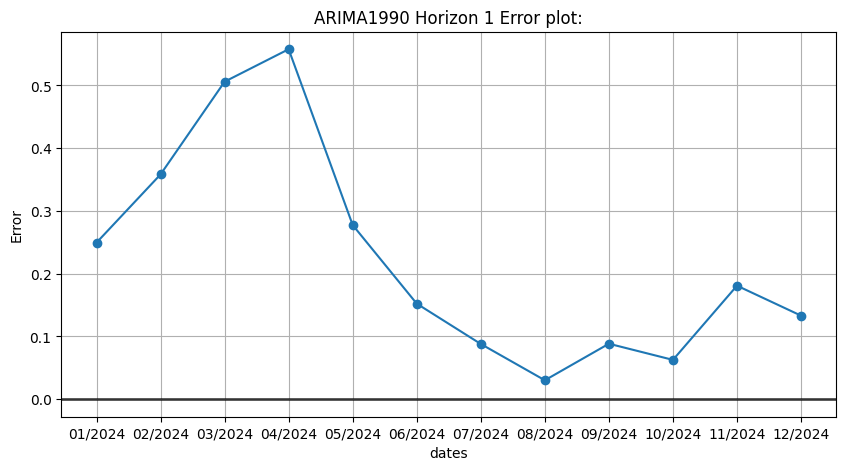

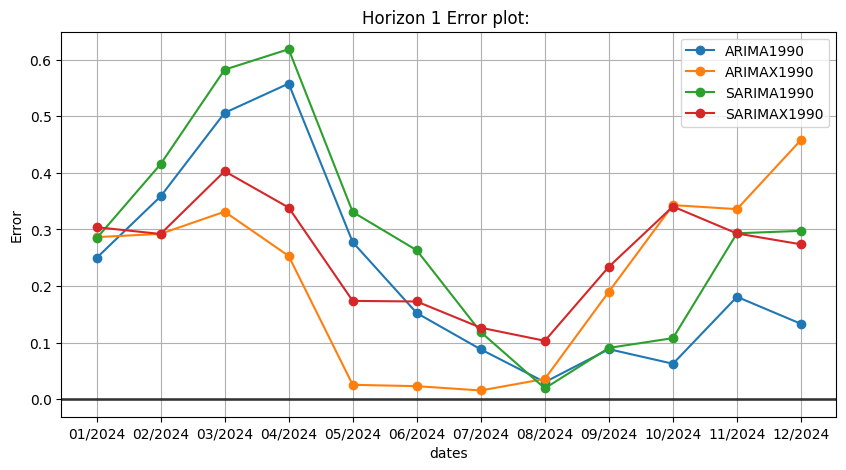

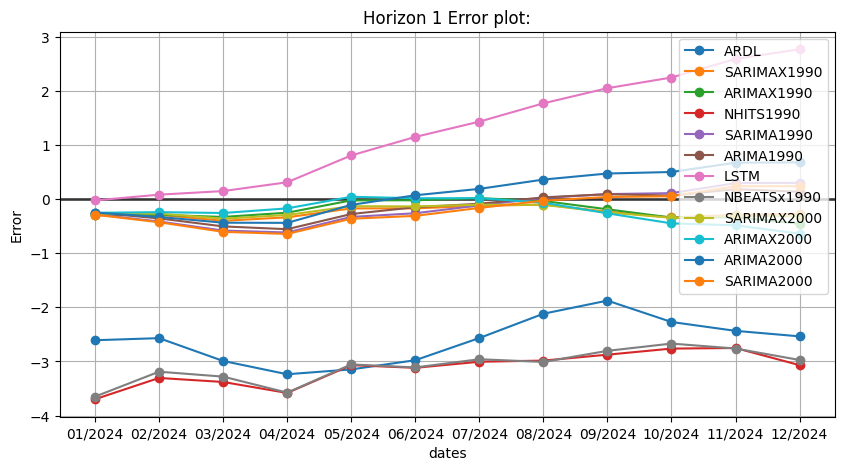

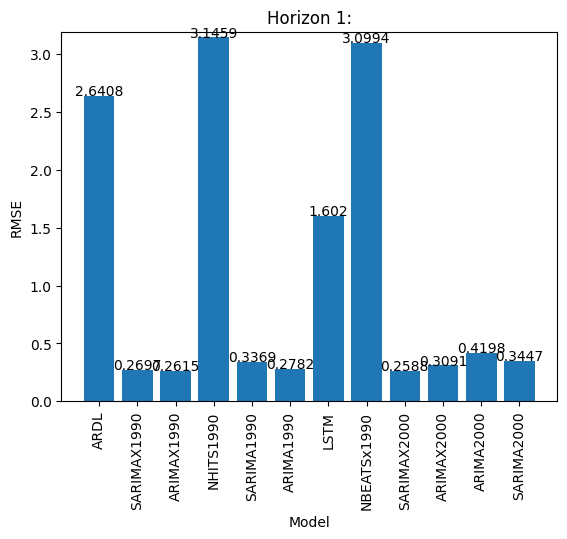

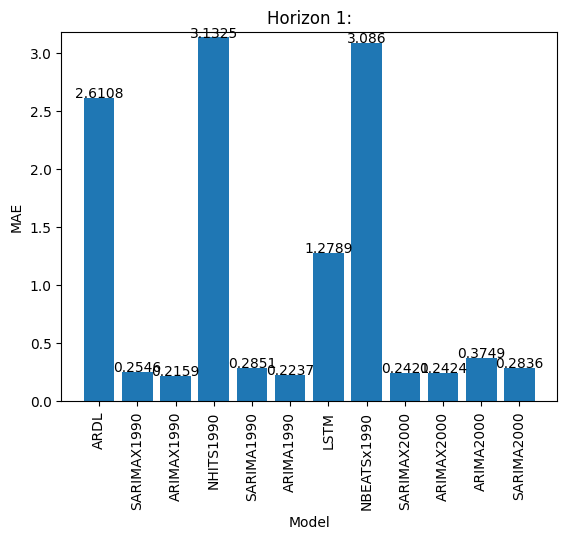

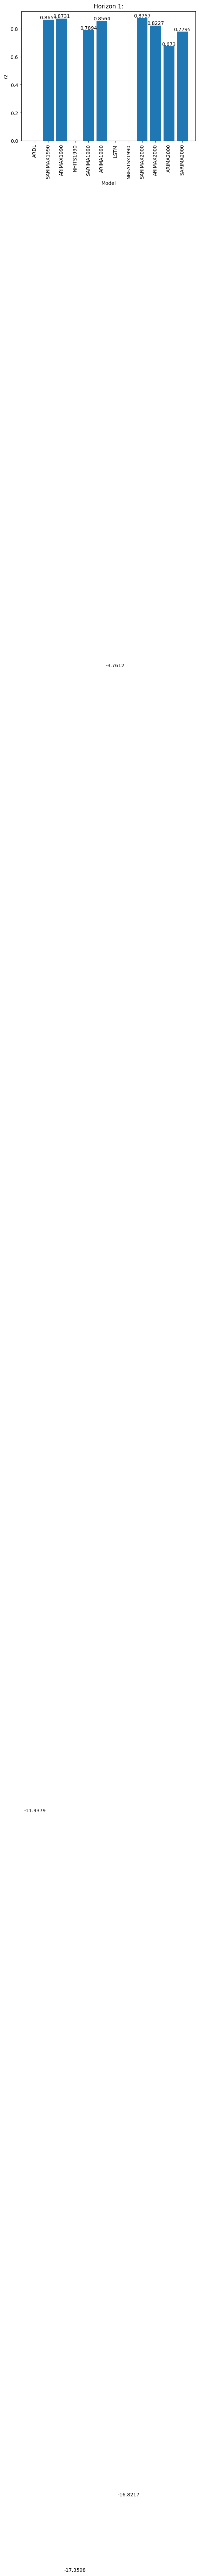

In [21]:
predsPath_1= Path('../Predictions/Horizon1')
predsDf_1=get_predictions(predsPath_1)

metrics_1= calc_metrics(predsDf_1)
display(metrics_1.sort_values(main_metric, axis=0))

error_plot(predsDf_1,model='ARIMA1990',absolute=True, title= 'ARIMA1990 Horizon 1 Error plot:')

error_plot(predsDf_1,model=['ARIMA1990','ARIMAX1990', 'SARIMA1990','SARIMAX1990'],absolute=True, title='Horizon 1 Error plot: ')
error_plot(predsDf_1,model='all',absolute=False, title= 'Horizon 1 Error plot:')

for i in metrics_1.columns:
    plot_metric(metrics_1,i, title='Horizon 1:')

# Horizon = 3:

,RMSE,MAE,r2
EXAMPLE,0.278222,0.22374,0.856396
LSTM,0.960128,0.758273,-0.710182
ARDL,2.537766,2.492736,-10.947779
NBEATSx1990,3.24316,3.212337,-18.512858
NHITS1990,3.245888,3.214122,-18.545702


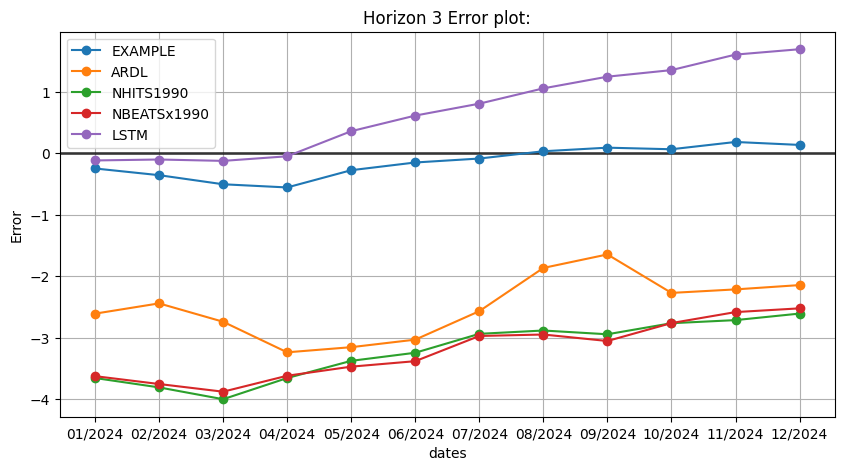

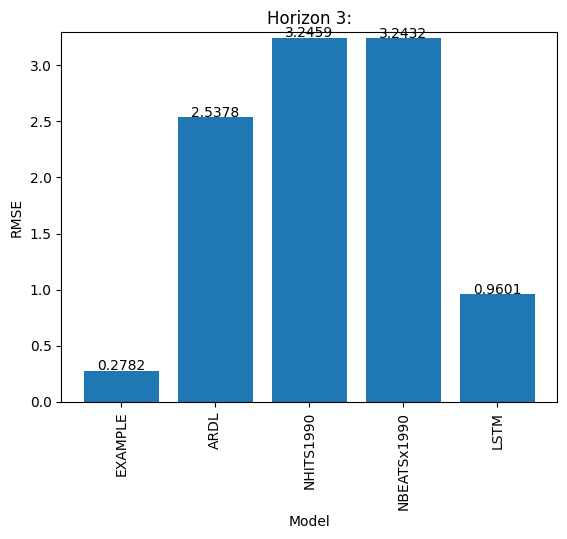

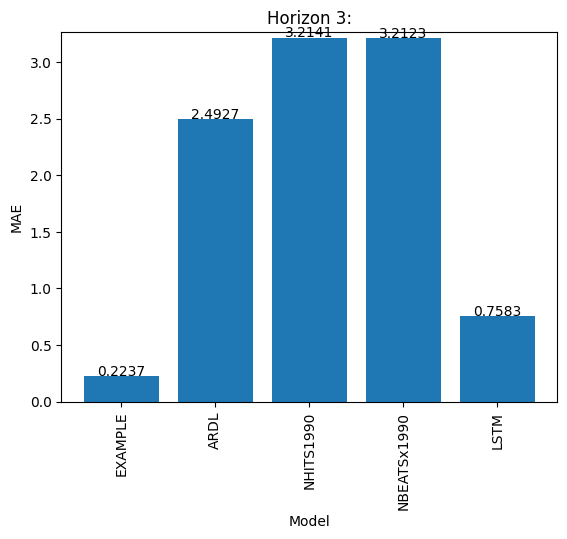

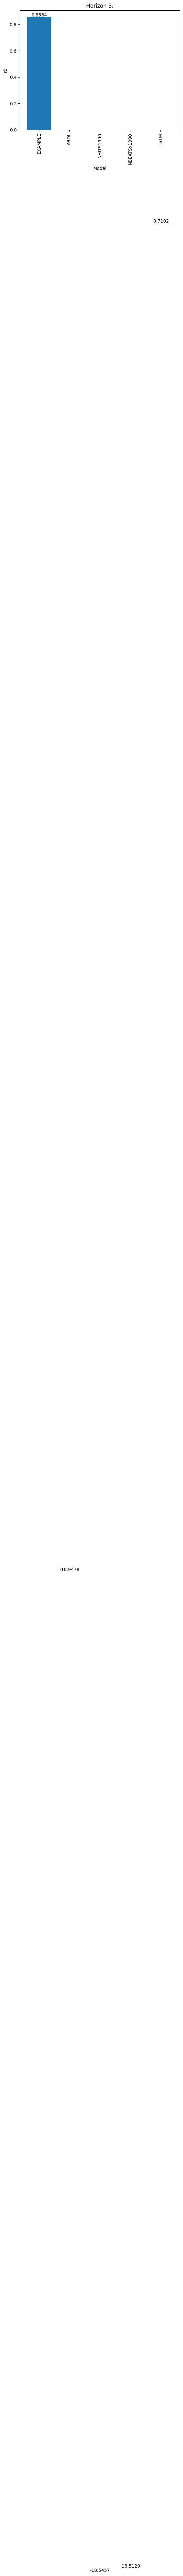

In [22]:
predsPath_3= Path('../Predictions/Horizon3')
predsDf_3=get_predictions(predsPath_3)

metrics_3= calc_metrics(predsDf_3)
display(metrics_3.sort_values(main_metric, axis=0))

error_plot(predsDf_3,model='all',absolute=False, title= 'Horizon 3 Error plot:')
for i in metrics_3.columns:
    plot_metric(metrics_3,i, title='Horizon 3:')

# Horizon = 6:

,RMSE,MAE,r2
EXAMPLE,0.278222,0.22374,0.856396
ARDL,2.271809,2.233214,-8.574754
NHITS1990,3.326016,3.300174,-19.522616
NBEATSx1990,3.476542,3.450648,-21.422246
LSTM,5.346032,4.639163,-52.02092


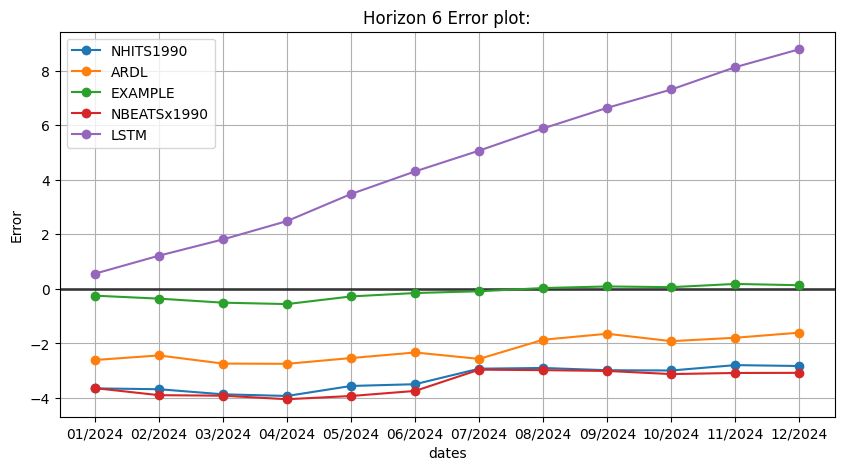

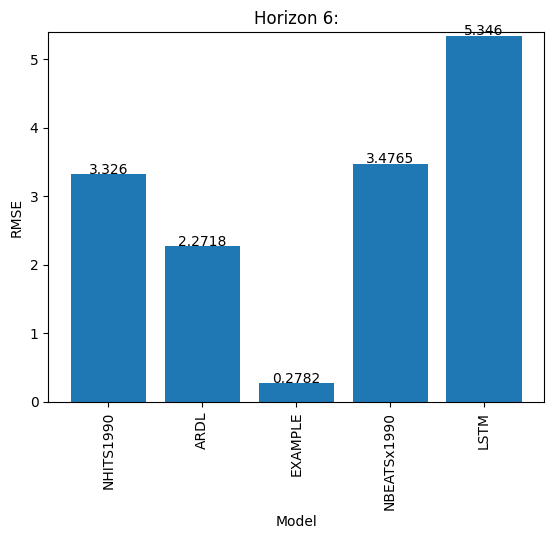

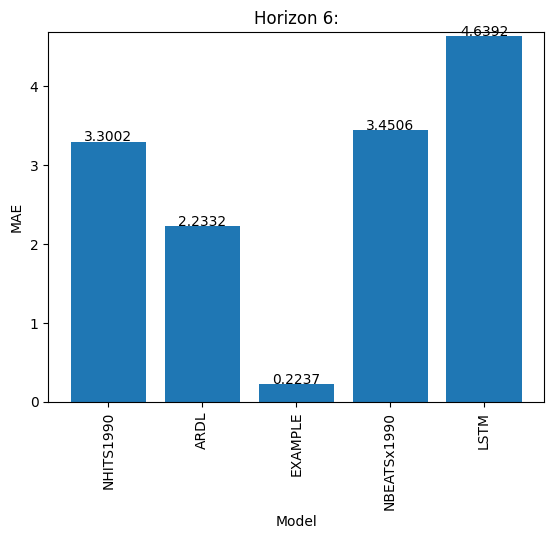

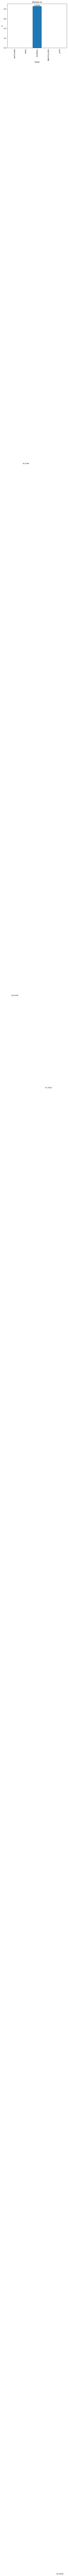

In [23]:
predsPath_6= Path('../Predictions/Horizon6')
predsDf_6=get_predictions(predsPath_6)

metrics_6= calc_metrics(predsDf_6)
display(metrics_6.sort_values(main_metric, axis=0))

error_plot(predsDf_6,model='all',absolute=False, title= 'Horizon 6 Error plot:')
for i in metrics_6.columns:
    plot_metric(metrics_6,i, title='Horizon 6:')

# Horizon = 12:

,RMSE,MAE,r2
EXAMPLE,0.278222,0.22374,0.856396
ARDL,2.108911,2.017296,-7.250887
NHITS1990,3.817656,3.814612,-26.038188
NBEATSx1990,4.143827,4.138137,-30.855714
LSTM,15.231358,13.187456,-429.389224


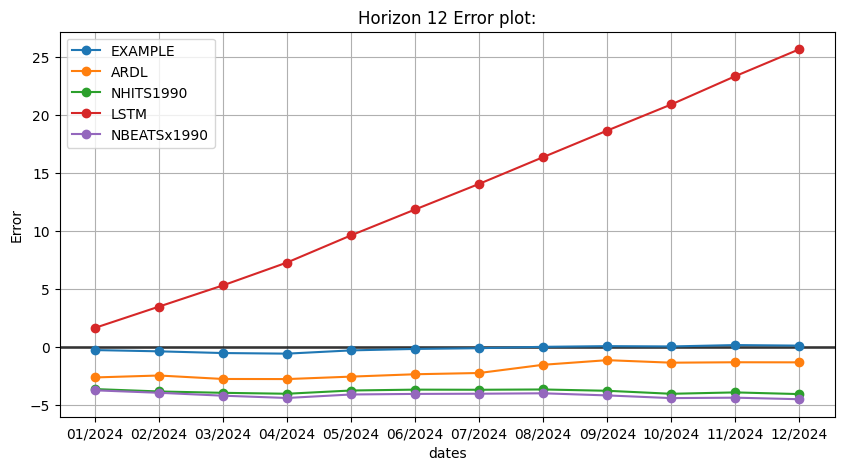

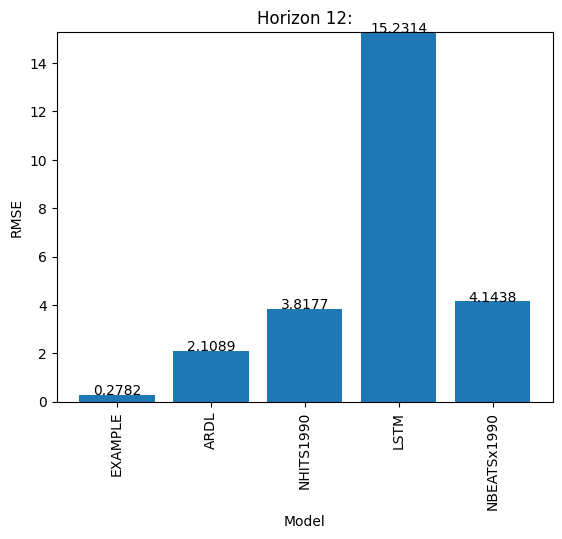

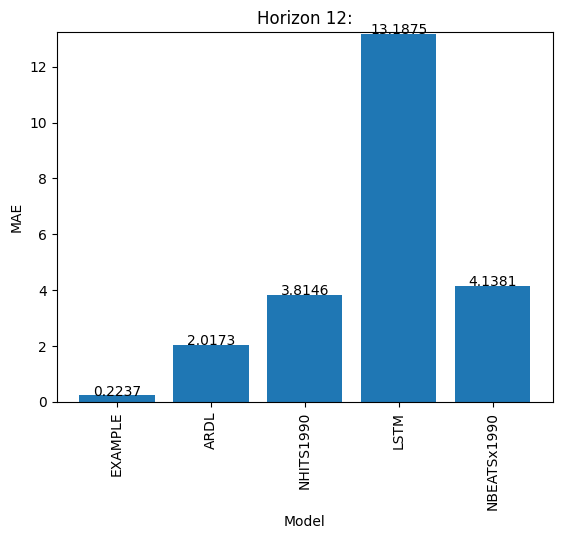

ValueError: Image size of 567x175504 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [24]:
predsPath_12= Path('../Predictions/Horizon12')
predsDf_12=get_predictions(predsPath_12)

metrics_12= calc_metrics(predsDf_12)
display(metrics_12.sort_values(main_metric, axis=0))

error_plot(predsDf_12,model='all',absolute=False, title= 'Horizon 12 Error plot:')
for i in metrics_12.columns:
    plot_metric(metrics_12,i, title='Horizon 12:')